# History Matching/EKI Comparison work
In this notebook we present the relevant figures that compare the history matching approach to the EKI approach. 

In [ ]:
import config 
import os 
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from glob import glob 
from joblib import Parallel,delayed,load,dump
from qbo_utils.qbo_ref import get_reference_qbo,fetch_qbo_file

BASE_EKI_EXPERIMENTS = { ## UPDATE PATHS with experiment result paths
    '5': '/Users/robcking/PhD/EKIDATA/N5',
    '10': '/Users/robcking/PhD/EKIDATA/N10',
    '20': '/Users/robcking/PhD/EKIDATA/N20',
    '50': '/Users/robcking/PhD/EKIDATA/N50',
}

BASE_HM_EXPERIMENTS = {
    '5':'/Users/robcking/PhD/history_matching_data/new/5_sample_exp',
    '10':'/Users/robcking/PhD/history_matching_data/new/10_sample_exp',
    '20':'/Users/robcking/PhD/history_matching_data/new/20_sample_exp',
    '50':'/Users/robcking/PhD/history_matching_data/new/50_sample_exp'
}
period,perioderr,amplitude,amplituderr= get_reference_qbo(fetch_qbo_file(local_path='./qbo.dat'))

## History Matching Centroid Evolution
Similar to the centroid evolution presented in the EKI convergence notebook, we present the equivalent plot for history matching

In [ ]:
def get_hm_centroids(hm_n:int):
    centroids = []
    spaces = sorted(
        glob(
            os.path.join(BASE_HM_EXPERIMENTS[str(hm_n)],'*.space')
            ),
        key=lambda x: re.search(r'\d+(?=.space)',x).group())
    for f in spaces:
        x = load(f).to_xarray().astype(int)
        denom = x.integrate(coord=('cwtropics','Bt_eq'))
        centroids.append([(x.cwtropics*x).integrate(coord=('cwtropics','Bt_eq'))/denom,(x.Bt_eq*x).integrate(coord=('cwtropics','Bt_eq'))/denom])
    return np.array(centroids)

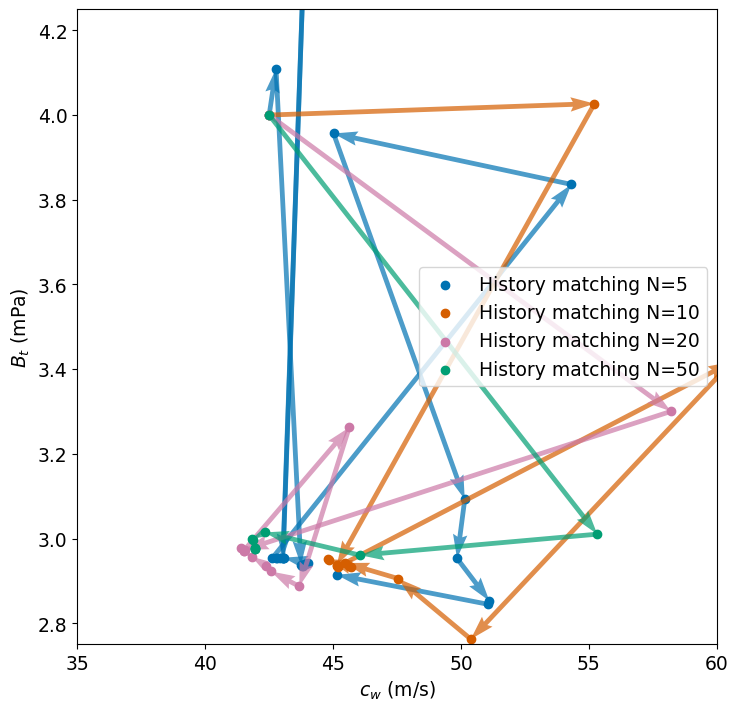

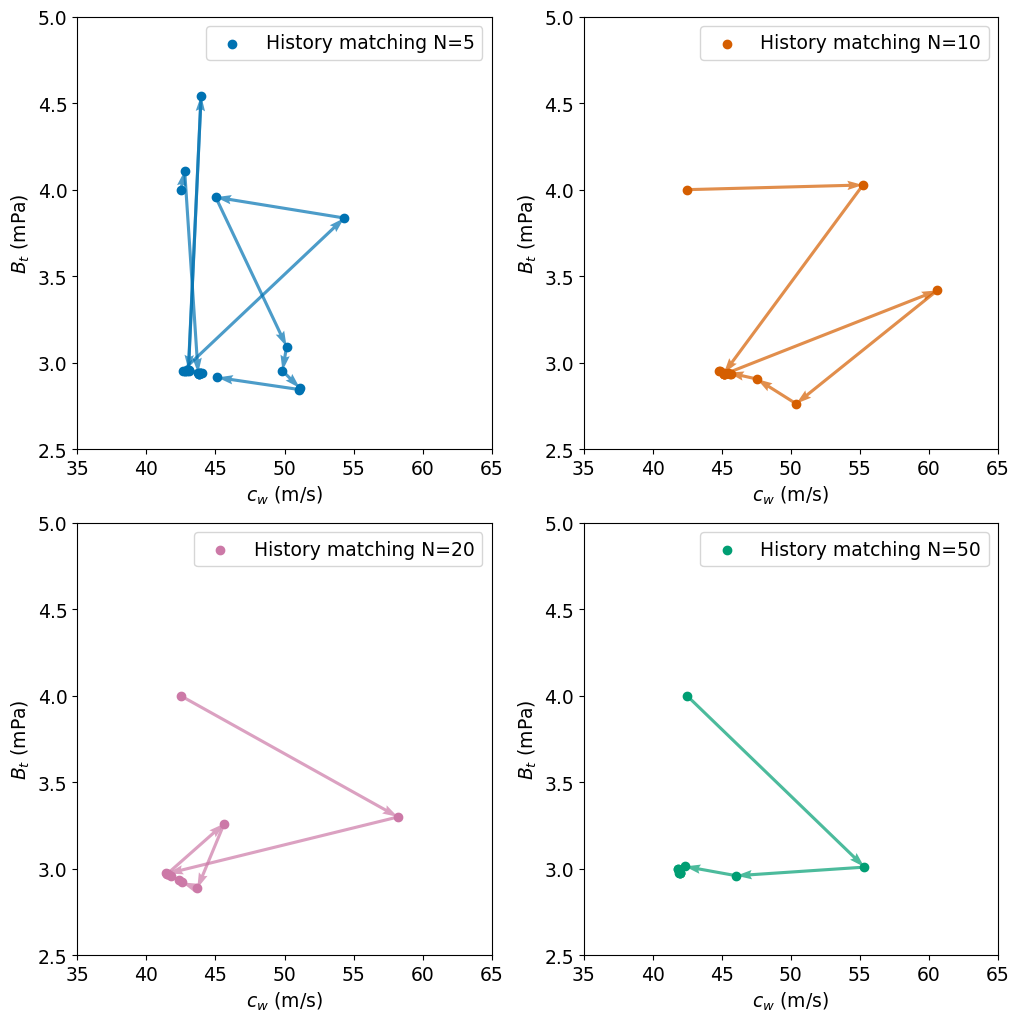

In [ ]:
hm_centroid_update = []
marker = ['o','o','o','o']
combfig,combaxs = plt.subplots(figsize=(8.25,8.25))
figs,axs = plt.subplots(2,2,figsize=(10.5,10.5))
figs.tight_layout(pad=2)
for (i,n),ax in zip(enumerate([5,10,20,50]),axs.ravel()):

    hm_centroid_update_n = []
    nroy_centroids = get_hm_centroids(n)
    ax.scatter(nroy_centroids[:,0],nroy_centroids[:,1]*1000,label=f'History matching N={n}',marker=marker[i],c=config.COLORS[str(n)],alpha=1.0)
    combaxs.scatter(nroy_centroids[:,0],nroy_centroids[:,1]*1000,label=f"History matching N={n}",marker=marker[i],c=config.COLORS[str(n)],alpha=1.0)
 
    for start,stop in zip(nroy_centroids[:-1],nroy_centroids[1:]):
        hm_centroid_update_n.append(np.sqrt(((stop[0]-start[0])/75)**2 + ((stop[1] -start[1])/0.006)**2))     
        ax.quiver(start[0],1000*start[1],stop[0] - start[0],1000*(stop[1] - start[1]),angles='xy',scale_units='xy',scale=1.0,alpha=0.7,color=config.COLORS[str(n)])
        combaxs.quiver(start[0],1000*start[1],stop[0] - start[0],1000*(stop[1] - start[1]),angles='xy',scale_units='xy',scale=1.0,alpha=0.7,color=config.COLORS[str(n)])
    hm_centroid_update.append(hm_centroid_update_n)
    # plt.legend()
    ax.set_xlabel("$c_w$ (m/s)")
    ax.set_ylabel("$B_t$ (mPa)")
    ax.set_xlim(35,65)
    ax.set_ylim(2.5,5)
    ax.legend()
combaxs.legend()
combaxs.set_xlabel("$c_w$ (m/s)")
combaxs.set_ylabel("$B_t$ (mPa)")
combaxs.set_xlim(35,60)
combaxs.set_ylim(2.75,4.25)
figs.savefig(f'figures/hm_centroids.png',dpi=230,bbox_inches='tight')
combfig.savefig(f'figures/hm_centroids_onefig.png',dpi=230,bbox_inches='tight')




## History Matching/EKI convergence comparison

### Run CES 
The below script runs CES and saves output samples to a directory named CES.

In [4]:
from tqdm.notebook import tqdm
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from history_matching.emulator.implausibility import (
    likelihood,
    chisquaredtest,
    implausibility2,
)
from history_matching.emulator import Emulator
from history_matching.samples import SampleSpace

CW_MIN = 5
CW_MAX = 80

BT_MIN = 0.001
BT_MAX = 0.007

N = 10000  ## NUMBER OF SAMPLES TO DRAW
burn_in = 5000  ## Consider this many samples as "burn in"

INIT_SPACE = SampleSpace.from_bound_dict(
    {"cwtropics": (CW_MIN, CW_MAX), "Bt_eq": (BT_MIN, BT_MAX)}
)

OBS = np.array([period, amplitude])
ERR = np.array([perioderr, amplituderr])


def draw_ces_samples(likelihood, N=1000, delta=0.5, burn_in=500):
    """
    Draw CES samples via Metropolis-Hastings Algorithm
    """
    x0 = np.random.uniform(low=[CW_MIN, BT_MIN], high=[CW_MAX, BT_MAX])
    delta = delta * np.diag([CW_MAX - CW_MIN, BT_MAX - BT_MIN])
    samples = np.empty((N, 2))
    samples[0] = x0
    for n in tqdm(range(N - 1)):
        cur_cw, cur_bt = samples[n]
        (next_cw, next_bt) = np.random.multivariate_normal(samples[n], delta**2)
        prior_next = (
            1 / ((CW_MAX - CW_MIN) * (BT_MAX - BT_MIN))
            if CW_MIN < next_cw < CW_MAX and BT_MIN < next_bt < BT_MAX
            else 0
        )
        prior_cur = (
            1 / ((CW_MAX - CW_MIN) * (BT_MAX - BT_MIN))
            if CW_MIN < cur_cw < CW_MAX and BT_MIN < cur_bt < BT_MAX
            else 0
        )
        likelihood_next = likelihood.interp(cwtropics=next_cw, Bt_eq=next_bt)
        likelihood_cur = likelihood.interp(cwtropics=cur_cw, Bt_eq=cur_bt)
        accept = np.min(
            [1, (prior_next * likelihood_next) / (prior_cur * likelihood_cur)]
        )
        if np.random.random() < accept:
            samples[n + 1] = np.array([next_cw, next_bt])
        else:
            samples[n + 1] = np.array([cur_cw, cur_bt])
    return samples[burn_in:]


# Iterate over all ensemble sizes in EKI
for n in (5, 10, 20, 50):
    samples = np.array(
        [
            pd.read_csv(f, index_col="run_id")[
                [
                    "cwtropics",
                    "Bt_eq",
                    "period",
                    "amplitude",
                    "period_sem",
                    "amplitude_sem",
                ]
            ].to_numpy()
            for f in sorted(
                glob(os.path.join(BASE_EKI_EXPERIMENTS[str(n)], "output_*.csv")),
                key=lambda x: int(re.search(r"(?<=_)\d+(?=.csv)", x).group()),
            )[:-1]
        ]
    )
    for wave in range(len(samples)):
        print(f"N={n},wave={wave}")
        X = np.concatenate(samples[: wave + 1, :, [0, 1]], axis=0)
        y = np.concatenate(samples[: wave + 1, :, [2, 3]], axis=0)
        y_err = np.concatenate(samples[: wave + 1, :, [4, 5]], axis=0)

        ## Handle NaN values
        nanwhere = np.isnan(y).any(axis=1)
        X = X[~nanwhere]
        y = y[~nanwhere]
        y_err = y_err[~nanwhere]

        em = Emulator(
            n_features=2,
            kernel=ConstantKernel() * RBF(length_scale_bounds=(0.05, 1))
            + WhiteKernel(),
            random_state=42,
        )
        em.fit(X, y, y_err=y_err)

        pred, predstd = em.predict_over_space(
            INIT_SPACE, return_std=True, resolution=1000
        )
        waveliklihood = likelihood(pred, predstd, OBS, ERR) / np.sqrt(
            (predstd**2 + ERR[:, None, None] ** 2).prod(dim="n_features")
        )
        print("Starting CES")

        if wave == 0:
            delta = 0.25  ## adaptive
        elif wave == 1:
            delta = 0.21
        else:
            delta = 0.12
        ces = draw_ces_samples(
            waveliklihood, N=N + burn_in, burn_in=burn_in, delta=delta
        )
        if not os.path.exists(f"ces_samples/{n}"):
            os.makedirs(f"ces_samples/{n}", exist_ok=True)
        np.save(f"ces_samples/{n}/{n}_{wave}_ces.npy", ces)
        dump(em,f"ces_samples/{n}/{n}_{wave}_em.em")

N=5,wave=0
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=1


/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=2
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=3


/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=4


/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=5


/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=6
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=7


/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=8
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=9
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=10
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=11
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=12
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=13
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=14
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=15
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=16
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=5,wave=17
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=0


/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=1
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=2
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=3
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=4
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=5
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=6
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=7
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=8
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=9
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=10
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=11
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=12
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=13
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=10,wave=14
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=0


/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=1
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=2
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=3
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=4
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=5
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=6
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=7
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=8
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=20,wave=9
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=0
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=1
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=2
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=3
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=4
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=5
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=6
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

N=50,wave=7
Starting CES


  0%|          | 0/14999 [00:00<?, ?it/s]

In [16]:
from history_matching.emulator.implausibility import (
    likelihood,
    chisquaredtest,
    implausibility2,
)
OBS = np.array([period, amplitude])
ERR = np.array([perioderr, amplituderr])
FILES = '/Users/robcking/PhD/history_matching_data/new/'

def get_all_samples(dir,n,nd=2):
    nsamples = len(glob(os.path.join(dir,'*.csv')))
    return np.array([pd.read_csv(os.path.join(dir,f'{p}_samples.csv'),index_col='run_id').to_numpy() for p in range(nsamples)])

def centroid(s):
    sxr = s.to_xarray().astype(int)
    denom = sxr.integrate(coord=s.coord_labels)
    return np.array(
        [
            (sxr[c] * sxr).integrate(coord=s.coord_labels) / denom
            for c in s.coord_labels
        ]
    )

def per_s(s,N_samples=10000):
    sxr = s.to_xarray()
    dx = (sxr.cwtropics.max() - sxr.cwtropics.min())/sxr.cwtropics.size
    dy = (sxr.Bt_eq.max() - sxr.Bt_eq.min())/sxr.Bt_eq.size
    area = 100*float(dx*dy*sxr.sum())/float(75*0.006)
    samples = s.uniform(n_samples=N_samples)
    norm_residuals = ((samples - centroid(s)))/np.array([75,0.006])
    avgspread = np.sqrt(np.mean(np.sum(norm_residuals**2,axis=-1)))
    return area,avgspread

def get_areas_and_spreads(n,N_samples=10000):
    path = os.path.join(FILES,f'{n}_sample_exp')
    space = [load(os.path.join(path,f'{p}.space')) for p in range(len(glob(os.path.join(path,'*.space'))))]
    arearmse = np.array(Parallel(n_jobs=-1, verbose=100)(delayed(per_s)(s,N_samples=N_samples) for s in space))
    arearmse[0,1] = np.sqrt(1/6)
    arearmse[0,0] = 100
    return arearmse[:,0],arearmse[:,1]

def get_eki_ratios(ces_sample_dir='ces_samples',space=None):
    if space is None:
        space =  SampleSpace.from_bound_dict({'cwtropics':(5,80),'Bt_eq':(0.001,0.007)})
    norm = space.to_xarray().integrate('cwtropics').integrate('Bt_eq')
    ratios = []
    for n in (5,10,20,50):
        ratio_n = []
        for emf in sorted(glob(os.path.join(ces_sample_dir,str(n),'*.em')),key=lambda x: int(re.search(r'(?<=_)\d+(?=_em)',x).group())):
            emulator = load(emf)
            pred,predstd = emulator.predict_over_space(space,return_std=True)
            imp2 = implausibility2(pred,predstd,OBS,ERR)
            nroy = chisquaredtest(imp2,0.01)
            ratio = nroy.integrate('cwtropics').integrate('Bt_eq')/norm
            ratio_n.append(float(ratio))
        ratios.append(ratio_n)
    return ratios

def get_eki_spreads(ces_sample_dir='ces_samples'):
    spreads = []
    for n in (5,10,20,50):
        spread_n= []
        for cesf in sorted(glob(os.path.join(ces_sample_dir,str(n),'*.npy')),key=lambda x: int(re.search(r'(?<=_)\d+(?=_ces)',x).group())):
            ces = np.load(cesf)
            ## Normalize axis 
            ces[:,0] = (ces[:,0] - 5)/75
            ces[:,1] = (ces[:,1] - 0.001)/0.006
            centroid = ces.mean(axis=0)
            norm_residuals = (ces - centroid)
            spread = np.sqrt(np.mean(np.sum(norm_residuals**2,axis=1)))
            spread_n.append(spread)
        spreads.append(spread_n)
    return spreads


In [13]:
areas5,spread5 = get_areas_and_spreads(5,1000)
areas10,spread10 = get_areas_and_spreads(10,1000)
areas20,spread20 = get_areas_and_spreads(20,1000)
areas50,spread50 = get_areas_and_spreads(50,1000)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done   4 out of  26 | elapsed:   53.2s remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of  26 | elapsed:  1.4min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   6 out of  26 | elapsed:  1.8min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   7 out of  26 | elapsed:  1.9min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   8 out of  26 | elapsed:  1.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   9 out of  26 | elapsed:  2.0min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  10 out of  26 | elapsed:  2.5min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  11 out of  26 | elapsed:  3.2min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  3.3min remaining:  3.9min
[Paralle

### EKI/History matching averaged normalized spread comparison

In [65]:
ekispreads = get_eki_spreads()
ekiratios = get_eki_ratios()

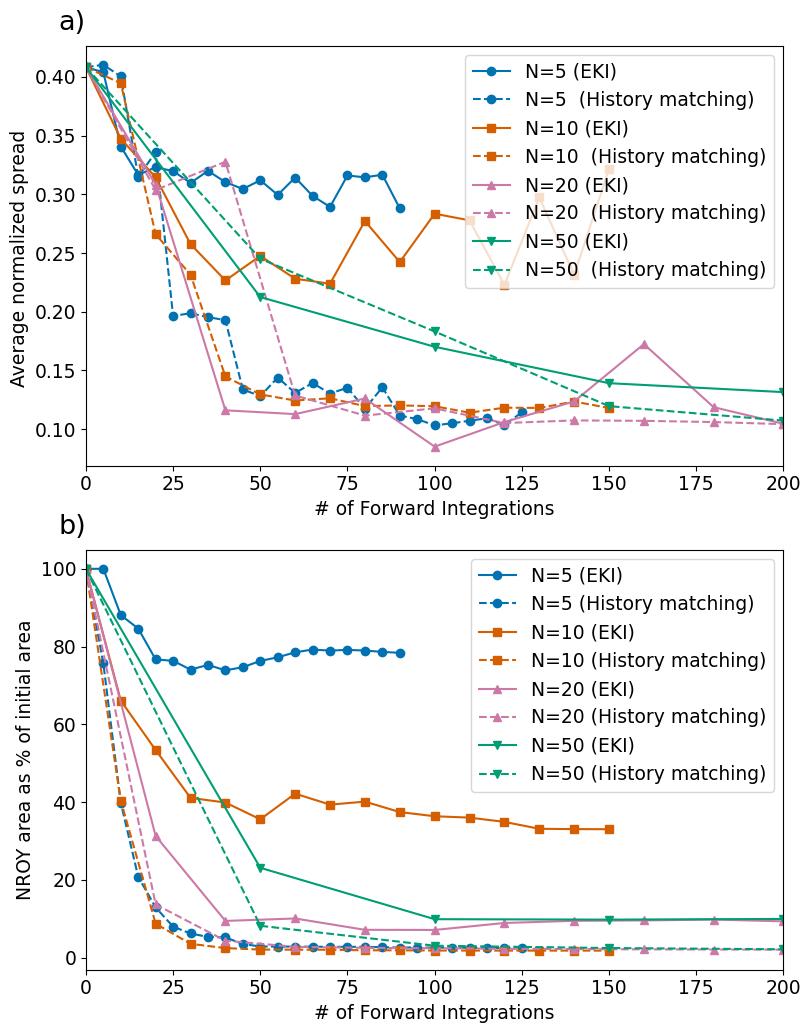

In [72]:
from history_matching.emulator import implausibility2
import matplotlib.transforms as mtransforms

fig,(axspread,axnroy) = plt.subplots(nrows=2,ncols=1,figsize=(9,12))
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
# plt.figure(figsize=(9,6))
marker = ['o','s','^','v']
for i,(n,spread,hm_spread) in enumerate(zip((5,10,20,50),ekispreads,(spread5,spread10,spread20,spread50))):
    x = np.arange(0,n*(len(spread)+1),n)
    xhm = np.arange(0,n*len(hm_spread),n)
    spread = np.array(spread)
    axspread.plot(x,[np.sqrt(1/6),*spread],label=f'N={n} (EKI)',color=config.COLORS[str(n)],marker=marker[i])
    axspread.plot(xhm,hm_spread,linestyle='--',label=f'N={n}  (History matching)',color=config.COLORS[str(n)],marker=marker[i])
axspread.legend()
axspread.set_xlim(0,200)
axspread.set_xlabel("# of Forward Integrations")
axspread.set_ylabel("Average normalized spread ")
axspread.text(0.0, 1.0, "a)", transform=axspread.transAxes + trans,
            fontsize='x-large', va='bottom', fontfamily='sans')

for i,(n,ratio,ratiohm)in enumerate(zip((5,10,20,50),ekiratios,(areas5,areas10,areas20,areas50))):
    x = np.arange(0,n*(len(ratio)+1),n)
    xhm = np.arange(0,n*len(ratiohm),n)
    ratio = np.array(ratio) * 100 
    axnroy.plot(x,[100,*ratio],label=f'N={n} (EKI)',color=config.COLORS[str(n)],marker=marker[i])
    axnroy.plot(xhm,ratiohm,linestyle='--',label=f'N={n} (History matching)',color=config.COLORS[str(n)],marker=marker[i])
axnroy.set_xlim(0,200)
axnroy.legend()
axnroy.set_xlabel("# of Forward Integrations") 
axnroy.set_ylabel("NROY area as % of initial area")
axnroy.text(0.0, 1.0, "b)", transform=axnroy.transAxes + trans,
            fontsize='x-large', va='bottom', fontfamily='sans')
fig.savefig('figures/combine_ces_hm_comparison.png',dpi=250,bbox_inches='tight')

#### EKI/History equivalent NROY Area Comparison

/Users/robcking/PhD/QBO-History-Matching/env/lib/python3.9/site-packages/history_matching/emulator/emulator.py:70: RuntimeWarning: invalid value encountered in multiply
  predictions = np.empty((self.n_features, *space_xr.shape)) * np.nan


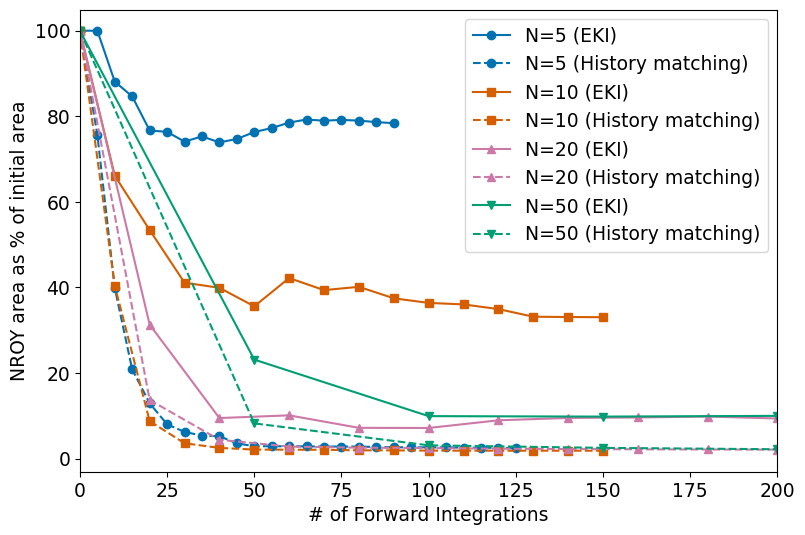

In [19]:
plt.figure(figsize=(9,6))
marker = ['o','s','^','v']
for i,(n,ratio,ratiohm)in enumerate(zip((5,10,20,50),get_eki_ratios(),(areas5,areas10,areas20,areas50))):
    x = np.arange(0,n*(len(ratio)+1),n)
    xhm = np.arange(0,n*len(ratiohm),n)
    ratio = np.array(ratio) * 100 
    plt.plot(x,[100,*ratio],label=f'N={n} (EKI)',color=config.COLORS[str(n)],marker=marker[i])
    plt.plot(xhm,ratiohm,linestyle='--',label=f'N={n} (History matching)',color=config.COLORS[str(n)],marker=marker[i])
plt.xlim(0,200)
plt.legend()
plt.xlabel("# of Forward Integrations") 
plt.ylabel("NROY area as % of initial area")
plt.savefig('figures/nroy_ces_hm_comp.png',bbox_inches='tight')

### EKI & History Matching compare posteriors
For visualization use N=10, iteration=6

In [19]:
N = 10 
SAMPLES = 10000
iteration = 6 # Convergence iteration for History Matching NROY
CES_SAMPLE_DIR='ces_samples'

In [20]:
from history_matching.samples import SampleSpace
hm_space:SampleSpace = load(os.path.join(BASE_HM_EXPERIMENTS[str(N)],f"{iteration}.space"))
hm_samples = hm_space.uniform(SAMPLES)




In [22]:
eki_ces_samples = np.load(os.path.join(CES_SAMPLE_DIR,str(N),f'{N}_{iteration}_ces.npy'))

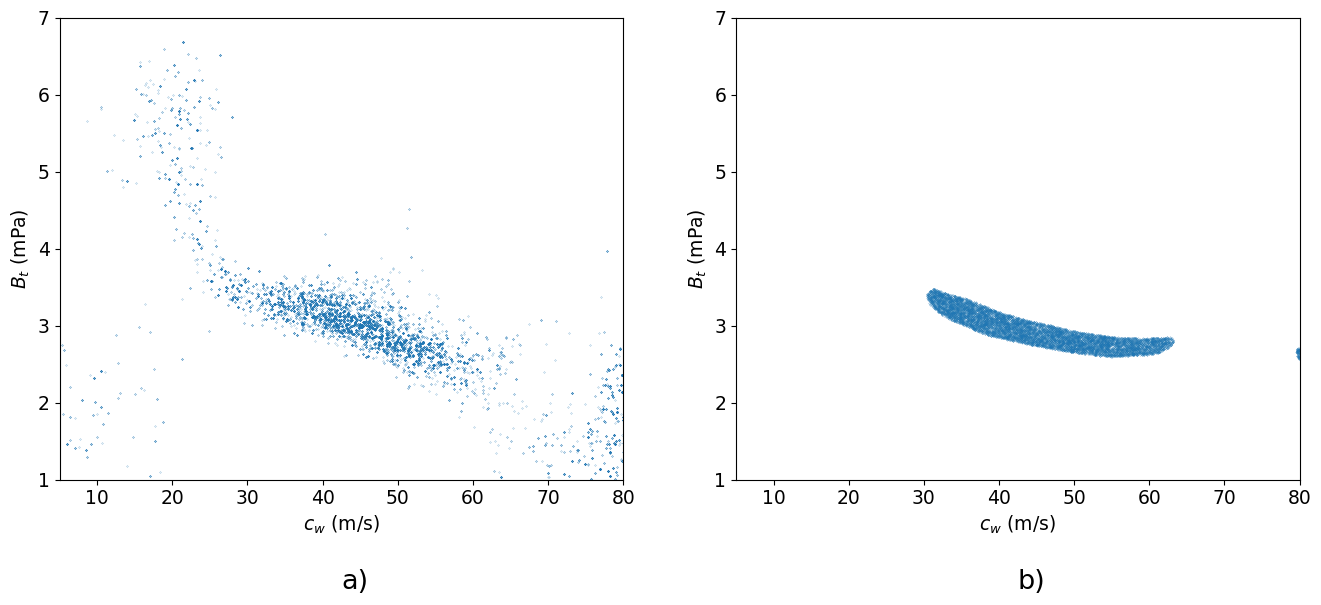

In [70]:
import matplotlib.transforms as mtransforms
fig,(axeki,axhm) = plt.subplots(nrows=1,ncols=2,figsize=(16,6))


axeki.scatter(eki_ces_samples[:,0],eki_ces_samples[:,1]*1000,s=0.03)
axeki.set_xlim(5,80)
axeki.set_ylim(1,7)
axeki.set_xlabel('$c_w$ (m/s)')
axeki.set_ylabel('$B_t$ (mPa)')
axhm.text(0.5, -0.25, "a)", transform=axeki.transAxes,
            fontsize='x-large', va='bottom', fontfamily='sans')
axhm.set_xlim(5,80)
axhm.set_ylim(1,7)
axhm.set_xlabel('$c_w$ (m/s)')
axhm.set_ylabel('$B_t$ (mPa)')
axhm.scatter(hm_samples[:,0],hm_samples[:,1]*1000,s=0.03)
axhm.text(0.5, -0.25, "b)", transform=axhm.transAxes,
            fontsize='x-large', va='bottom', fontfamily='sans')
fig.savefig('figures/comb_eki_ces_samples.png',bbox_inches='tight')
